## Monocular Depth Estimation with Supervised Learning

This file contains the main driver code for training and evaluation.

In [1]:
import os
import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image_folder = "./data/images/"
depth_folder = "./data/depths/"

image_paths = [image_folder + file for file in os.listdir(image_folder)]
depth_paths = [depth_folder + file for file in os.listdir(depth_folder)]

assert len(image_paths) == len(depth_paths)

### Visualize the Data

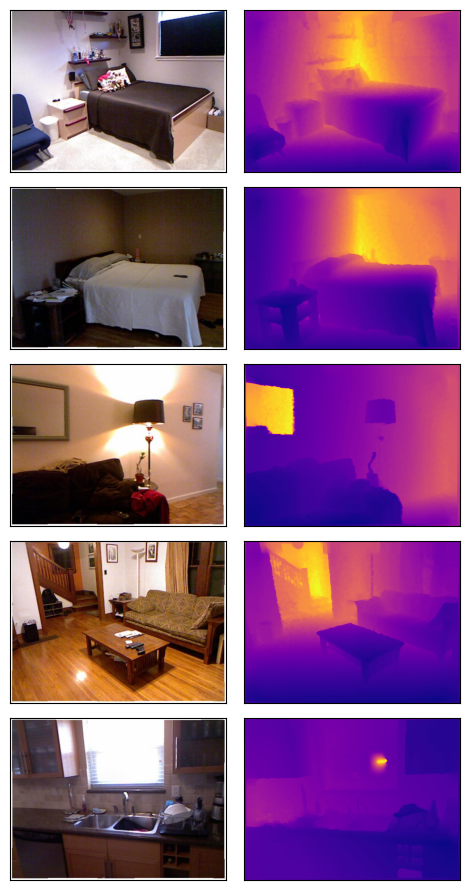

In [2]:
num_samples = 5
sample_idxs = np.random.choice(len(image_paths), num_samples)

fig, ax = plt.subplots(num_samples, 2, figsize=(5, 9))

for i, idx in enumerate(sample_idxs):
    for axis in ax[i]:
        axis.set_xticks([]), axis.set_yticks([])
    ax[i][0].imshow(Image.open(image_paths[idx]))
    ax[i][1].imshow(np.load(depth_paths[idx]), cmap="plasma")

plt.tight_layout()
plt.show()

### Split the Dataset

In [3]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_depths, val_depths = train_test_split(
    image_paths, depth_paths, test_size=0.2, random_state=42
)

len(train_images), len(train_depths), len(val_images), len(val_depths)

(1159, 1159, 290, 290)

In [4]:
import torch
from torch.utils.data import DataLoader
from src.dataset import ImgDataset
from src.loss import Loss
from src.network import UNet


BATCH_SIZE = 16
NUM_WORKERS = 0

train_set = ImgDataset(train_images, train_depths, augment=False)
val_set = ImgDataset(val_images, val_depths, augment=False)

train_dataloader = DataLoader(
    dataset=train_set,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    batch_size=BATCH_SIZE,
)

validation_dataloader = DataLoader(
    dataset=val_set,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    batch_size=BATCH_SIZE,
)

### Build the Model & Train

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet()
model.to(device)
criterion = Loss()
criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, eps=1e-08)

In [6]:
epochs = 50

for epoch in range(1, epochs + 1):
    model.train()
    tr_loss = nb_tr_steps = 0
    time_start = time.time()

    for step, batch in enumerate(train_dataloader, start=1):
        batch = tuple(t.to(device) for t in batch)
        b_images, b_depths = batch

        model_output = model(b_images)
        loss = criterion(model_output, b_depths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_steps += 1

    model.eval()
    val_loss = nb_val_steps = 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_images, b_depths = batch

        with torch.no_grad():
            model_output = model(b_images)
            loss = criterion(model_output, b_depths)

        val_loss += loss.item()
        nb_val_steps += 1

    print(
        "Epoch {} | Train loss: {:.4f} | Val loss: {:.4f} | Time (s): {:.2f}".format(
            epoch,
            tr_loss / nb_tr_steps,
            val_loss / nb_val_steps,
            time.time() - time_start,
        )
    )

Epoch 1 | Train loss: 0.3797 | Val loss: 0.3665 | Time (s): 17.52
Epoch 2 | Train loss: 0.3533 | Val loss: 0.3451 | Time (s): 16.86
Epoch 3 | Train loss: 0.3227 | Val loss: 0.3374 | Time (s): 17.04
Epoch 4 | Train loss: 0.3109 | Val loss: 0.3179 | Time (s): 16.60
Epoch 5 | Train loss: 0.3055 | Val loss: 0.3118 | Time (s): 16.37
Epoch 6 | Train loss: 0.3004 | Val loss: 0.3422 | Time (s): 16.41
Epoch 7 | Train loss: 0.2959 | Val loss: 0.3127 | Time (s): 16.36
Epoch 8 | Train loss: 0.2923 | Val loss: 0.3176 | Time (s): 16.37
Epoch 9 | Train loss: 0.2894 | Val loss: 0.3074 | Time (s): 16.37
Epoch 10 | Train loss: 0.2859 | Val loss: 0.3106 | Time (s): 16.35
Epoch 11 | Train loss: 0.2794 | Val loss: 0.3098 | Time (s): 16.36
Epoch 12 | Train loss: 0.2757 | Val loss: 0.2986 | Time (s): 16.36
Epoch 13 | Train loss: 0.2706 | Val loss: 0.3083 | Time (s): 16.35
Epoch 14 | Train loss: 0.2627 | Val loss: 0.3030 | Time (s): 16.43
Epoch 15 | Train loss: 0.2529 | Val loss: 0.3004 | Time (s): 16.36
Epoc

### Predict Using the Trained Model

#### Predict on Training Data

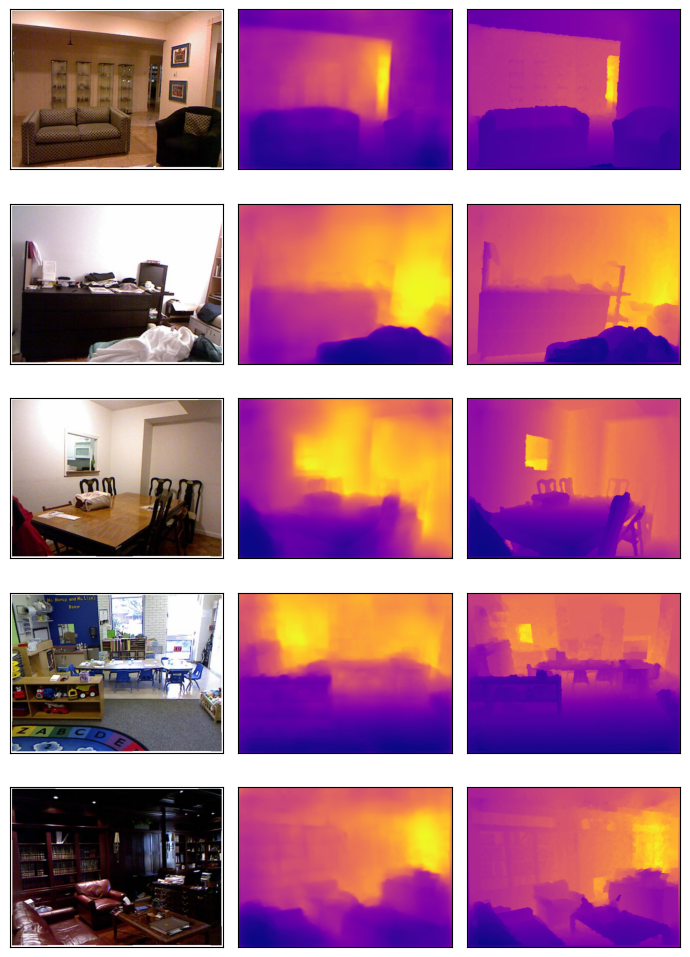

In [10]:
sample_idxs = np.random.choice(len(train_images), 5)

fig, ax = plt.subplots(5, 3, figsize=(7, 10))

for i, idx in enumerate(sample_idxs):
    img = train_set[idx][0].to(device)

    with torch.no_grad():
        model_output = model(img.unsqueeze(0))

    for axis in ax[i]:
        axis.set_xticks([]), axis.set_yticks([])
    ax[i][0].imshow(Image.open(train_images[idx]))
    ax[i][1].imshow(model_output.cpu().numpy().squeeze(), cmap="plasma")
    ax[i][2].imshow(np.load(train_depths[idx]), cmap="plasma")

plt.tight_layout()
plt.show()

#### Predict on Validation Data

In [11]:
test_preds = []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_images, b_depths = batch

    with torch.no_grad():
        model_output = model(b_images)
        test_preds.extend(model_output.cpu().numpy())

test_preds = np.concatenate(test_preds)

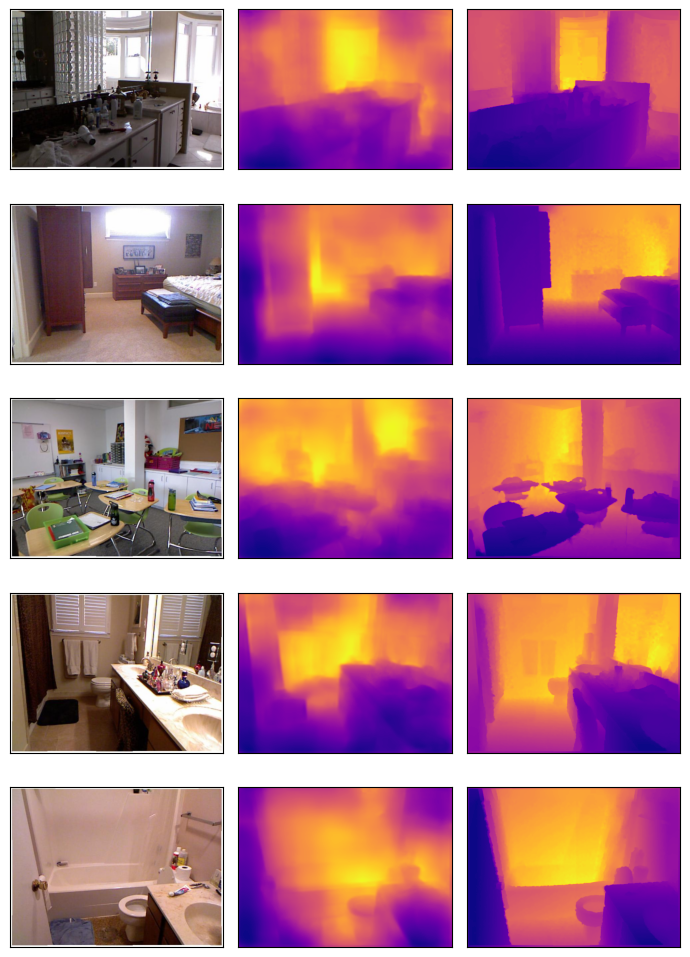

In [12]:
sample_idxs = np.random.choice(test_preds.shape[0], 5)

fig, ax = plt.subplots(5, 3, figsize=(7, 10))

for i, idx in enumerate(sample_idxs):
    for axis in ax[i]:
        axis.set_xticks([]), axis.set_yticks([])
    ax[i][0].imshow(Image.open(val_images[idx]))
    ax[i][1].imshow(test_preds[idx], cmap="plasma")
    ax[i][2].imshow(np.load(val_depths[idx]), cmap="plasma")

plt.tight_layout()
plt.show()